# Multinomial Logit

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
import matplotlib.pyplot as plt 

import w10_mlogit_ante as mlogit
import w10_mlogit_estimation as est

%load_ext autoreload
%autoreload 2

Introduction
============

In this week's problem set, you are asked to investigate how alcohol
abuse affects employment status. Individuals can either be outside of
the labour market, unemployed or employed. This means, that the
dependent variable has three discrete outcomes. We use the multinomial
logit model to express the probability of individuals to be either
outside the labour market, unemployed or employed. This model is a
generalization of the logit model we looked at in problem set 9 (binary
choice) which only allowed for the dependent variable to have two
discrete outcomes.

The dataset consists of two things for each $i$, $(y_i, \mathbf{x}_i)$, 
where $y_i \in \{1,...,J\}$, and $\mathbf{x}_i$ is a $K\times 1$ vector 
of explanatory variables relating to the individuals. 

In the multinomial logit the probability of observing choice $j$ for
household $i$ given the observed explanatory variables, $\mathbf{x}_{i}$ is given
as,
$$
\text{Pr}\left(y_{i}=j\mid \mathbf{x}_{i},\boldsymbol{\beta}_j\right) \equiv p_{ij}
    =\frac{\exp( \mathbf{x}_{i}\boldsymbol{\beta}_j )}
          {\sum_{k=1}^{J}\exp\left(\mathbf{x}_{i}\boldsymbol{\beta}_k\right)}
          ,\quad j=1,\dots J \tag{1}
$$

The probabilities lie between 0 and 1 since
$\exp(\mathbf{x}_{i}\boldsymbol{\beta}_j)>0$ and they sum to one over the
$J$ alternatives. The expression,
(1), can be derived from an underlying latent
utility model, where taste shocks follow an extreme value type 1
distribution. The data-generating process of this latent utility model
can be formalized as

$$
\begin{aligned}
y_{i} &= \operatorname*{argmax}_{j=1,\ldots,J} \{u_{ij}\},  \tag{2} \\
u_{ij} &= \mathbf{x}_{i} \boldsymbol{\beta}_j + \varepsilon_{ij}, \qquad \varepsilon_{ij} \sim \text{IID Extreme Value} , 
\end{aligned}
$$

where the utility, $u_{ij}$, consists of a deterministic part,
$v_{ij}=\mathbf{x}_i\boldsymbol{\beta}_j$, and a stochastic part, $\varepsilon_{ij}$. Individual
$i$ chooses the alternative $y_i\in \{1,\ldots,J\}$ that is associated
with the highest level of $u_{ij}$ after having observed the iid extreme
value type 1 distributed shocks, $\varepsilon_{ij}$ for
$j\in\{1,\ldots,J\}$. It is important to note that the individual 
observes everything in $u_{ij}$, so it is a simple thing to pick the 
$j$ that has the highest utility. The challenge for the econometrician is 
that the error terms $\varepsilon_{ij}$ are not in the dataset. 

Fortunately, it can be shown that if one simulates data according to the 
Data Generating Process (DGP) above, then the choice probabilities in (1) 
are correct.

It turns out that the model is only identified under a *normalization 
assumption*, such as $\boldsymbol{\beta}_1 := \mathbf{0}_{K\times 1}$.
That is, we cannot identify a parameter on a regressor, $\beta_{kj}$, 
for all alternatives $j=1,...,J$. The argument why this is the case is 
presented in this youtube video: https://youtu.be/IeDJN6VQtLg. 
Intuitively, the argument boils down to the fact that we can only identify 
effects that change the utility of an option *relative* to other options. 
This is because we only observe the *argmax* of utility and thus cannot 
hope to identify the *scale* of utility, since utility is merely ordinal. 

# Question 1: Simulate Data 

The first task is to finish the code in the function
`sim_data(N, J, theta)` in the `mlogit` module. This
function simulates a data set with $N$ individuals choosing between $J$ alternatives. The third input is a parameter vector,
$\theta=(\beta_1^\prime,\ldots,\beta_J^\prime)^\prime$ and $j=1$ is the baseline alternative $\beta_1=0$.

The function simulates a $N \times K$ matrix of covariates. These
consist of a constant term and K-1 individual characteristics drawn from a standard normal distribution, i.e.
$x_{i}= (1,x_{i2}, \ldots, x_{iK})'$, with $x_{ik} \sim N(0,1)$.

The choice pattern is simulated in accordance with the data generating
process given by the equations in
(2).

*Note:*
The solution to this is exactly as we simulated data for the clogit last week. The main difference is that we now have beta coefficients for each option (last week we had one column of beta coefficients, today we have (J - 1) columns of beta coefficients.). As mentioned, we use the first option J = 0 as a baseline.

***Programming hint:*** We will simulate `x` as `(N, K)`, i.e. there is no column for the normalized alternative. We can still use matrix algebra to compute the $N \times J$ matrix of utilities with characteristic element 
$$ 
v_{ij} = \sum_{k=1}^K x_{ijk} \beta_{jk} \quad \text{for } \ne 1,
$$ 
and $v_{i1} = 0$. We can compute this using 
```Python
xb = x @ theta # x is (N, K) and theta is (K, J-1), so the product is (N, J-1)
oo = np.zeros((N,1)) # normalized util=0 for the baseline
u = np.hstack([oo,xb]) # full (N,J) matrix of utilities (hstack = horizontal stack)
```
The product `x @ theta` works because `x` is `(N,J-1,K)` and `theta` is `(K,J-1)`. Then Python interprets it as we expect. 

In [2]:
# Initialize simulation parameters
N = 10000
J = 3
K = 2

# Initialize true beta coefficients for data generating process.
beta2 = np.array([[-.3, .6]]).T
beta3 = np.array([[.2, -1]]).T
true_beta = np.hstack([beta2, beta3])
theta0 = np.zeros((K, J - 1)) # zeros are safe starting values, resulting in equal probabilities

In [3]:
# simulate some data 
np.random.seed(1)
y,x = mlogit.sim_data(true_beta, N)

In [4]:
print('Frequencies of y:')
pd.value_counts(y)

Frequencies of y:


C:\Users\annal\AppData\Local\Temp\ipykernel_11212\378394915.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y)


2    4250
0    2943
1    2807
Name: count, dtype: int64

Expected output:

| y         | Frequencies  | 
|:----------|-------------:|
|2          |   4250       |
|0          |   2943       |
|1          |   2807       |

# Question 2: Choice Probabilities 

The choice probabilities in the multinomial logit model is given by
equation (1). This should be implemented into the mlogit.m
class file such that the function
`choice_prob()` returns choice probabilities, $p_{ij}$ for
$i\in \{1,\ldots,N\}$ and $j\in \{1,\ldots,J\}$. The choice
probabilities are contained in the ($N \times J$) matrix `ccp`. The function should also return the (natural)
$\log$ of the choice probabilities which is used later in the maximum
likelihood estimation. The log transformed choice probabilities, which should be saved in the matrix `logccp`,
are given by
$$
\log\text{Pr}\left(y_{i}=j\mid \mathbf{x}_{ij},\boldsymbol{\beta}\right)=\log p_{ij}=\mathbf{x}_{i}\boldsymbol{\beta}_j-\log\left(\sum_{m=1}^{J}\exp\left(\mathbf{x}_{i}\boldsymbol{\beta}_m\right)\right),
$$

*Programming hint*:
Again, this is done exactly like last week, except that you need a loop for each column of coefficients we have for the choices when you calculate the utility matrix. Remember that the first column in the utility matrix is the baseline, and therefore should be a column with only zero values.

In [5]:
ccp, logccp = mlogit.choice_prob(theta0, x)
np.isclose(ccp[0,0], 0.33333333)

np.True_

In [6]:
ccp, logccp = mlogit.choice_prob(true_beta, x)
np.isclose(ccp[0,0], 0.31211691)

np.True_

# Question 3: Estimate on Simulated Data

Last time you created the criterion function for the conditional logit estimator. This is identical to the criterion function for the multinomial logit model, so you need only to copy this from last week.

Now estimate the coefficients based on the simulated data, using maximum likelihood to solve the model. To do this use the `estimate` function.

I have written some code that calculates the norm of the gradient at the point of the solution. We will use this later to solve any issues we might have in a real, empirical example. Should this norm be large or small?

In [9]:
sim_result = est.estimate(mlogit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.932552
         Iterations: 17
         Function evaluations: 90
         Gradient evaluations: 18


In [10]:
varnames = [f'x{j+1}{k+1}' for j in range(1,J) for k in range(K)]
pd.DataFrame({
              'Est' : sim_result["theta"], 
              's.e.': sim_result["se"], 
              'True': true_beta.flatten() # pd expects flat arrays 
             },
             index=varnames).round(4)

,Est,s.e.,True
x21,-0.2973,0.0306,-0.3
x22,0.1944,0.0264,0.2
x31,0.5909,0.0321,0.6
x32,-1.0230,0.0314,-1.0


Expected output:

|   |Est       |	s.e.  |	True|
|:--|---------:|---------:|----:|    
|x21|	-0.2973|	0.0306|	-0.3|
|x22|	 0.1944|	0.0264|  0.2|
|x31|	 0.5909|	0.0321|	 0.6| 
|x32|	-1.0230|	0.0314|	-1.0|

In [11]:
def calc_norm(q, theta):
    g = est.centered_grad(q, theta) # (N,K)
    g = np.mean(g, axis=0) # (K,)
    return np.mean(g ** 2) # 2-norm: 

In [12]:
q = lambda theta: np.mean(mlogit.q(theta, y, x))
print(f'q(thetahat)        = {q(sim_result["theta"]): 8.4g}')
print(f'2-norm of gradient = {calc_norm(q, sim_result["theta"]): 8.4g}')

q(thetahat)        =   0.9326
2-norm of gradient =  2.76e-11


# Question 4: Estimation on the Terza (2002) data

We are now going to use the data from 
>   Joseph V. Terza (2002): "Alcohol abuse and employment: A second look"
>   Journal of Applied Econometrics, Volume 17, Issue 4, Pages 393-404

Data source: http://qed.econ.queensu.ca/jae/2002-v17.4/terza/


We will use the data to estimate the
multinomial logit model. Therefore, we need to first load the data and
then use the proper functions coded previously. 

The outcome, `y`, can take $J = 3$ values: 
* `0` if they are out of the work force, 
* `1` if they are unemployed, and 
* `2` if they are employed. 

Out of the work force, `0`, will be the normalized baseline alternative for our analysis.

The results we are looking to obtain are shown in the table below, although some of them are rescaled, so you might have too many commas for some coefficients:

|           |   Unemployed |   (t, unemployed) |    Employed |   (t, employed) |
|:----------|-------------:|------------------:|------------:|----------------:|
| alcohol   |   0.126952   |         0.584267  | -0.153571   |       -1.08658  |
| urate     |   0.0457542  |         0.83962   | -0.0955165  |       -2.78256  |
| age       |   0.162471   |         2.41517   |  0.227685   |        5.44668  |
| agesq     |  -0.00244618 |        -3.0253    | -0.00308571 |       -6.33359  |
| schooling |  -0.00923555 |        -0.340401  |  0.0890395  |        6.04366  |
| married   |   0.400316   |         2.1345    |  0.708421   |        6.17536  |
| famsize   |   0.0621845  |         1.24317   |  0.0622035  |        1.96377  |
| white     |   0.0391827  |         0.221582  |  0.738065   |        7.0695   |
| excellent |   2.91856    |         6.41338   |  3.70305    |       20.4199   |
| verygood  |   2.97854    |         6.47601   |  3.65356    |       19.507    |
| good      |   2.49418    |         5.5087    |  2.99973    |       17.2925   |
| fair      |   1.46049    |         2.98686   |  1.87639    |       10.2903   |
| northeast |   0.0843054  |         0.349563  |  0.0887303  |        0.592707 |
| midwest   |   0.0155177  |         0.0739923 |  0.122884   |        0.944845 |
| south     |   0.174895   |         0.840669  |  0.439299   |        3.44955  |
| center    |  -0.271521   |        -1.38227   | -0.268834   |       -2.21096  |
| other     |  -0.091874   |        -0.472643  |  0.0980203  |        0.7822   |
| firstq    |   0.422726   |         2.08176   | -0.0272806  |       -0.209783 |
| secondq   |  -0.0214781  |        -0.100532  | -0.11056    |       -0.868604 |
| thirdq    |  -0.0361932  |        -0.166545  | -0.0529623  |       -0.412258 |
| const     |  -6.12662    |        -4.12252   | -6.24737    |       -6.66383  |

Final likelihood: `q = 0.3276` 

```      
     Value of the log-likelihood function: -3217.48
```


I have written the code to load the data. Use this data to estimate a multinomial logit model using the `estimate()` function, and print it using the `print_table()` function.

You might get an error that states that the minimizer is unsure whether it found a solution. Reuse the code from above and check the size of the norm at the solution. Remember that you have to redefine `q` as well. Does the norm look fine to you?

In [14]:
data = np.loadtxt('w10_terza.txt') # numpy array 

# y takes values 0: out of work force, 1: unemployed, 2: employed
y_lab = 'Labor outcome'
x_lab = ['alcohol', 'urate', 'age', 'agesq', 'schooling', 'married', 'famsize', 'white', 
         'excellent', 'verygood', 'good', 'fair', 
         'northeast', 'midwest', 'south', 'center', 'other', 
         'firstq', 'secondq', 'thirdq']
y_values_lab = ['Out of labor force', 'Unemployed', 'Employed']

# to inspect in a cleaner way
df = pd.DataFrame(data, columns=[y_lab] + x_lab)
df.sample(3)

,Labor outcome,alcohol,urate,age,agesq,schooling,married,famsize,white,excellent,...,good,fair,northeast,midwest,south,center,other,firstq,secondq,thirdq
8627,3.0,0.0,5.7,36.0,1296.0,18.0,1.0,3.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2431,3.0,1.0,3.0,26.0,676.0,16.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1093,3.0,0.0,3.0,28.0,784.0,12.0,0.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [15]:
y = data[:, 0] - 1  # Subtract 1 to make y base 0
x = data[:, 1:]

y = y.astype(int)
N = y.size

# add constant to x 
oo = np.ones((N, 1))
x = np.hstack((data[:, 1:], oo))
K = x.shape[1]
x_lab.append('const')

J = len(np.unique(y))

theta0 = np.zeros((K, J-1))

In [16]:
np.unique(y)

array([0, 1, 2])

In [19]:
# Estimate the model using est.estimate() and mlogit.q, returning the results dictionary 
mlogit_result = est.estimate(mlogit.q, theta0,y,x) # Fill in

         Current function value: 0.327579
         Iterations: 283
         Function evaluations: 13858
         Gradient evaluations: 322


c:\Users\annal\anaconda\Lib\site-packages\scipy\optimize\_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [20]:
q = lambda theta: np.mean(mlogit.q(theta0, y, x))
print(f'q(thetahat)        = {q(sim_result["theta"]): 8.4g}')
print(f'2-norm of gradient = {calc_norm(q, sim_result["theta"]): 8.4g}')

q(thetahat)        =    1.099
2-norm of gradient =        0


In [21]:
# print results from the result dictionary 

# we reshape the parameters in the same way as is done inside the utility function 
# this is because scipy.optimize.minimize works on a "flattened" (1-dim) array
thetahat = mlogit_result['theta'].reshape(K, J-1) 
t        = mlogit_result['t'].reshape(K, J-1)

tab = pd.DataFrame({
    'Unemployed': thetahat[:,0], '(t, unemployed)': t[:,0],
    'Employed':   thetahat[:,1], '(t, employed)':   t[:,1]
},index=x_lab)
tab

,Unemployed,"(t, unemployed)",Employed,"(t, employed)"
alcohol,0.127000,0.584488,-0.153548,-1.086414
urate,0.045754,0.839622,-0.095516,-2.782544
age,0.162465,2.415088,0.227681,5.446595
agesq,-0.002446,-3.025214,-0.003086,-6.333513
schooling,-0.009236,-0.340411,0.089039,6.043643
married,0.400320,2.134518,0.708425,6.175397
famsize,0.062184,1.243165,0.062203,1.963755
white,0.039177,0.221549,0.738066,7.069507
excellent,2.918562,6.413375,3.703057,20.419874
verygood,2.978563,6.476049,3.653574,19.507118


In [16]:
# Calculate the norm of the gradient

In [22]:
q = lambda theta: 1/N * np.sum(mlogit.q(theta, y, x))
g = est.centered_grad(q, mlogit_result["theta"]) # gradient at parameter estimates 
print(f'q(thetahat)          = {q(mlogit_result["theta"]): 8.4g}')
print(f'2-norm of gradient   = {np.mean(g ** 2): 8.4g}')
print(f'inf-norm of gradient = {np.mean(np.abs(g)): 8.4g}')


q(thetahat)          =   0.3276
2-norm of gradient   =  1.23e-07
inf-norm of gradient =  6.821e-05


# Question 5: Odds Ratio

Consider a particular individual represented by
the row vector of covariates
$x_0 = (0, 6, 40, 40^2, 8, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1)$
where the first element indicates that the individual does not abuse
alcohol ($x_0[1]= 0$). Note that to facilitate convergence we need to
again rescale some of the covariates. Following the rescale proposed in
the ex-post code, the vector of covariates will become
$x_0 = (0, 0.6, 4, 1.6, 0.8, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1)$.

The odds ratio measures the probability of a given outcome to
occur relative to the probability of a baseline outcome, conditional on
the covariates. It is defined as:

$$
\begin{aligned}
\frac{\Pr(y_i=j|\mathbf{x}_i)}{\Pr(y_i=1|\mathbf{x}_i)} = \frac{\frac{\exp \{ \mathbf{x}_{i}\boldsymbol{\beta}_j \}}{ \sum_{l=1}^J \exp \{ \mathbf{x}_{i}\boldsymbol{\beta}_l \}}}   {\frac{\exp \{ \mathbf{x}_{i}\boldsymbol{\beta}_1 \}}{ \sum_{l=1}^J \exp \{ \mathbf{x}_{i}\boldsymbol{\beta}_l \}}} = \exp\{\mathbf{x}_i \boldsymbol{\beta}_j\}
\end{aligned}
$$

The odds ratio of being employed is therefore calculated as
$x_0 \beta_3$, where $\beta_3$ is the vector of parameters
estimated for the third outcome (being employed).

- Calculate the odds ratio of being unemployed (should be around `0.593`).
- Calculate the odds ratio of being employed  (should be around `5.742`).

How do we interpret these odds ratios?

In [23]:
# Consider some person
x0 = np.array([[0, 6, 40, 40*40, 8, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]]).reshape(1, K)

x1 = x0.copy()
i_alco = 0 # variable corresponding to alcohol
x1[0, i_alco] = 1.0 # sets alcohol abuse := 1 
thetahat = mlogit_result['theta'].reshape(K, J-1)

In [47]:
pd.DataFrame(x0, columns=x_lab, index=['Fictitious individual, "x0"']).T

,"Fictitious individual, ""x0"""
alcohol,0
urate,6
age,40
agesq,1600
schooling,8
married,0
famsize,2
white,1
excellent,0
verygood,0


In [50]:
# odds ratio of being unemployed/employed vs being out of labor force
odds_unemp = np.exp(x0 @thetahat[:,0]) # fill in, hint: pick thetahat only for j=0 (unemployed) and remember thetahat is Kx(J-1), J=3
odds_emp   = np.exp(x0 @thetahat[:,1]) # fill in, hint: pick thetahat only for j=1 (employed) and remember thetahat is Kx(J-1), J=3
print(f'{odds_unemp[0]:.3f}')
print(f'{odds_emp[0]:.3f}')

0.596
5.760


Expected output: 0.597 and 5.761

# Question 6: Marginal Effects (discrete case)

The marginal effect of a change in a binary covariate is computed by
subtracting the conditional choice probability under the two possible
values of the binary covariate $k$ (with and without alcohol
abuse): 
$$
\begin{aligned}
\delta^d_j(x_{ik})=Pr(y_i=j|x_{ik}=1)-Pr(y_i=j|x_{ik}=0)
\end{aligned}
$$

- Cacluate the choice probability for person $x0$.
- Cacluate the choice probability for the same person but now with alcholoh abuse set to 1 (`k=0`).
- Subtrace the choice probability of x1 from x0.
- You should get values close to `[ 0.0154  0.0211  -0.0365]`

In [53]:
def marg_effect_discrete(betahat, x0, x1):
    # Calculate the probabilities of x1 and x0, using betahat of the latest model estimation.
    # Then subtract the probability vector of x0 from the probability vector of x1.
    prob_x1,_ = mlogit.choice_prob(betahat, x1) # Fill in: choice probability matrix at x1 
    prob_x0,_ = mlogit.choice_prob(betahat, x0) # Fill in: choice probability matrix at x0
    return (prob_x1 - prob_x0).flatten()

In [54]:
me_alc = marg_effect_discrete(thetahat, x0, x1)

tab = pd.DataFrame({'Marginal effect (alcohol)': me_alc}, index=y_values_lab).round(4)
tab

,Marginal effect (alcohol)
Out of labor force,0.0152
Unemployed,0.0213
Employed,-0.0364


Expected results: 

|                    |   Marginal effect (alcohol) |
|:-------------------|----------------------------:|
| Out of labor force |                      0.0152 |
| Unemployed         |                      0.0213 |
| Employed           |                     -0.0364 |

# Question 7: Marginal Effects (continuous case)

- Calculate the marginal effect of education (`schooling`, with `k=4`) using the above equation. $\beta_{jk}$ is given to you.
- You should get values close to `[-0.00940 -0.00632  0.0157]`

The marginal effect for the multinomial logit model with respect to a
continuous covariate $k$ (e.g., schooling) is:
$$
\begin{aligned}
\frac{\partial \Pr(y_i=j\mid x_i)}{\partial x_{ik}} = p_{ij} \left(\beta_{jk} - \sum_{l=1}^J p_{il}\beta_{lk}\right).
\end{aligned}
$$

We can calculate the full vector of marginal effects, 
$(  \frac{\partial \Pr(y_i=0\mid x_i)}{\partial x_{ik}}, 
    \frac{\partial \Pr(y_i=1\mid x_i)}{\partial x_{ik}}, 
    \frac{\partial \Pr(y_i=2\mid x_i)}{\partial x_{ik}}
)$, by using vector notation: 
$$
\frac{\partial\mathbf{p}_{i}}{\partial x_{ik}}=\mathbf{p}_{i}\left(\boldsymbol{\beta}_{k}-\sum_{l=1}^{J}p_{il}\beta_{lk}\right),
$$ where $\mathbf{p}_i$ is the $3 \times 1$ vector $(p_{i0}, p_{i1}, p_{i2})$, and (in an unforgivable abuse of notation) $ \boldsymbol{\beta}_k = (\beta_{0k}, \beta_{1k}, \beta_{2k})$ (a $J$-vector). Thus, the sum $\sum_l p_{il} \beta_{lk}$ can be written as the inner "dot" product of $\mathbf{p}_i$ and $\boldsymbol{\beta}_k$. (And the coefficient for alcohold is $k = 4$ (in base 0).) 


In [59]:
def marg_effect_continuous(thetahat, theta_k, x):
    '''
        theta: (N,J-1) matrix of coefficients
        theta_k: J-vector of coefficients on the k'th covariate
        x: (N,K) matrix (possibly just N=1) of covariates
    '''
    N,K = x.shape
    K,J_1 = thetahat.shape
    J = J_1 + 1 # only coefficients for J-1 alternatives 
    
    # 0. input checks 
    assert theta_k.ndim     == 2, f'"theta_k" should not be flattened (ndim==2 required)'
    assert theta_k.shape[0] == J, f'"theta_k" should be {J=}, but got {theta_k.shape[0]}'
    assert theta_k.shape[1] == 1, f'"theta_k" must be a column J-vector'
    
    # 1. compute derivative: return flattened (N*J, )
    prob, _ = mlogit.choice_prob(thetahat, x) 
    # Fill in 
   # 1. compute derivative: return flattened (N*J, )

    p_bet = prob @ theta_k
    diff = theta_k - p_bet
    prob_diff = prob.T * diff # elementwise product
    return (prob_diff).flatten()

In [60]:
thetahat_educ = np.hstack([0.0, thetahat[4, :]]).reshape(J,1)
me_educ = marg_effect_continuous(thetahat, thetahat_educ, x0).flatten()

tab = pd.DataFrame({'Marginal effect (education)': me_educ}, index=y_values_lab).round(6)
tab

,Marginal effect (education)
Out of labor force,-0.009375
Unemployed,-0.006341
Employed,0.015715


Expected results: 

|                    |   Marginal effect (education) |
|:-------------------|----------------------------:|
| Out of labor force |                   -0.009374 |
| Unemployed         |                   -0.006341 |
| Employed           |                    0.015715 |

#### Testing our derivative with a numerical derivative
To test our results, we can also simply compute a finite difference partial effect wrt. the $k$'th entry in `x0`. To do so, we want to use the simple standard formula for a numerical derivative 
$$ f'(x) \cong \frac{f((1+h)x)-f(x)}{hx}, \quad \text{for }h \text{ small.} $$
However, the function `mlogit.choice_prob` takes several inputs, and they are in vector form, so we write a small "wrapper function" that takes only a *scalar* as input, `x_k`, and fixes the remaining values and calls `mlogit.choice_prob`. 

In [61]:
# numerical partial derivative  
k = 4
def f(x_k): 
    '''choice_prob_handle: Function handle taking *scalar* inputs (for doing a numerical first difference)'''
    assert np.isscalar(x_k), 'This function is defined for scalar values'
    # x0 comes from "global" memory scope (set outside this function)
    x0_ = np.copy(x0).astype(float) # we take a copy to avoid overwriting x0 (in python, you can write to inputs)
    x0_[:,k] = x_k # we change the k'th regressor, setting it equal to the scalar input everywhere 
    prob, _ = mlogit.choice_prob(thetahat, x0_) # evaluate choice probabilities on the new x0 
    return prob

# compute numerical finite difference
h = 1e-8
x0_k = x0[0,k] # years of education in our x0 vector 
f0 = f(x0_k)        # base
f1 = f(x0_k*(1+h))  # forward step 
me_educ_num = (f1 - f0) / (h*x0_k)   # newton quotient
print(me_educ_num) # verify that this gives the same numbers

[[-0.00937472 -0.00634054  0.01571526]]


## Bootstrapping to get standard errors of marginal effects.

Since we are not able to directly calculate variances for the marginal effects, we can use bootstrapping instead. This is done by taking a sample of our data, but with replacement. This means that we create a new data set as a random draw from our original data set, but we allow that the same observation is drawn multiple times. This new data set has the same number of observations as the original, but will differ sligthly since we now (may) have some duplicates.

The procedure works as follows: 
* For each bootstrap iteration do: 
    1. Draw bootstrap sample (with replacement) 
    2. Estimate $\hat{\theta}$
    3. Compute marginal effects using 1-2. 

We do this for many bootstrap iterations and then calculate the empirical standard deviation of the stored marginal effects over bootstrap iterations. This standard deviation is what we will use as our estimate of the *standard error* of the marginal effects. 

Do this in 4 steps: 
1. Write a function that, for a given dataset, `y`,`x`, runs estimation and computes marginal effects (2, 3). 
2. Write a function that draws a bootstrap sample with replacement from the original dataset. 
3. Run the bootstrap procedure. 
4. Print results. 

### Part 1: Estimating and computing marginal effects in one go

First, we write a function that does everything we did above, given an input dataset, `y`, `x`
1. Estimate parameters, 
2. Compute marginal effect for alcohol (discrete) 
3. Compute marginal effect for education (continuous)
    - Construct the $J$-sub-vector of education betas (adding the normalized $\theta_{40}=0$ in front)
    - Compute marginal effect using the analytic formula 

In [64]:
def estimate_and_compute_marg_effs(y, x, x0, x1, theta_start, disp=False): 
    '''Estimate and compute marginal effects
    Args. 
        y: N-vector of discrete outcomes
        x: N*J matrix of explanatory variables
        x0: K-vector of explanatory variables 
        x1: K-vector, alcohol switched on 
        
    Returns
        tuple of floats: 
            me_alco: marginal effect wrt. alcohol (discrete)
            me_educ: marginal effect wrt. education (continuous)
    '''
    assert y.ndim == 1 , 'y must be a flattened array'
    assert x.ndim == 2 , 'x must be 2-dimensional'
    assert theta_start.ndim == 2, 'theta_start should be 2-dimensional'
    assert theta_start.shape[0] == x.shape[1], 'theta_start and x should conform'
    
    N,K = x.shape
    _,J_1 = theta_start.shape 
    J = J_1 + 1 
    
    # 1. estimate 
    res = est.estimate(mlogit.q, theta_start, y, x, options={'disp':disp})
    betahat = res['theta'].reshape(K,J-1)
    
    # 2. marginal effect of alcohol 
    me_alco = marg_effect_discrete(betahat, x0, x1)
    
    # 3. marginal effect of education 
    # 3.a sub-vector of parameters 
    bet_educ = np.hstack([0.0, betahat[4,:]]).reshape((J,1))
    # 3.b marg. effect
    me_educ = marg_effect_continuous(betahat, bet_educ, x0)
    
    # 4. return 
    return me_alco, me_educ

Evaluate the function for our baseline dataset and note how long it takes. 

In [65]:
%%time 
me_alco, me_educ = estimate_and_compute_marg_effs(y,x,x0,x1,theta_start=thetahat)
print(f'Alco: {me_alco.round(4)}')
print(f'Educ: {me_educ.round(4)}')

Alco: [ 0.0152  0.0213 -0.0364]
Educ: [-0.0094 -0.0063  0.0157]
CPU times: total: 9.5 s
Wall time: 2.41 s


Expected results:

Alco: [ 0.0152  0.0213 -0.0364] 

Educ: [-0.0094 -0.0063  0.0157]

### Part 2: Function to draw a bootstrap sample

The function should draw *indices* for the observations (rows) to be drawn. 
* *Hint:* Look at the function `np.random.choice(Nmax, Nsamples, replace=True)`. 

In [66]:
def bootstrap_sample(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N = y.size
    
    # FILL IN 
    ii_boot = np.random.choice(N, size=N, replace=True) # vector of indices for rows 

    y_i = y[ii_boot] # selection of N rows from y 
    x_i = x[ii_boot] # selection of N rows from x 
    
    return y_i, x_i 

### Part 3: Run the bootstrap procedure

In [69]:
nboot = 10  # Number of bootstraps, should ideally be very large 

# Set seed for random sampling.
seed = 42
rng = default_rng()

# initialize 
me_alco = np.empty((nboot,J))
me_educ = np.empty((nboot,J))

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. choose which individuals to draw
    y_i, x_i = bootstrap_sample(y, x) # Fill in: call the bootstrap sample function 
    # 2. estimate and compute 
    ma, me = estimate_and_compute_marg_effs(y_i, x_i, x0, x1, theta_start=thetahat)
    me_alco[i,:] = ma
    me_educ[i,:] = me

Bootstrap iteration 1/10
Bootstrap iteration 2/10
Bootstrap iteration 3/10
Bootstrap iteration 4/10
Bootstrap iteration 5/10
Bootstrap iteration 6/10
Bootstrap iteration 7/10
Bootstrap iteration 8/10
Bootstrap iteration 9/10
Bootstrap iteration 10/10


### Part 4: Show the results 

***Note:*** For results to believable in practice, the number of bootstrap repetitions needs to be quite high, over 100 and preferably 1000. 

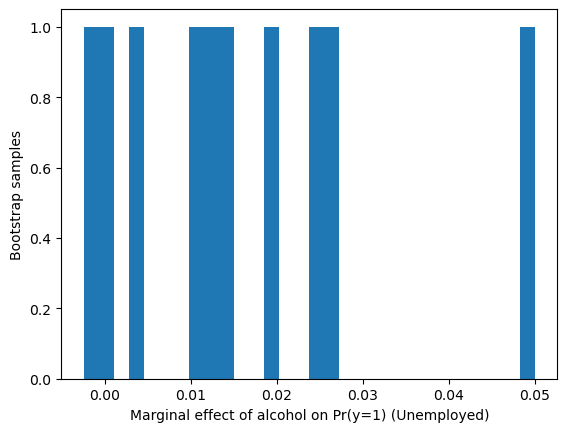

In [70]:
j = 1
plt.hist(me_alco[:, j], bins=30); 
plt.xlabel(f'Marginal effect of alcohol on Pr(y={j}) ({y_values_lab[j]})'); 
plt.ylabel('Bootstrap samples'); 

Here is a function to make a semi-nice table to print the coefficients, and their 95% confidence interval.

In [71]:
from tabulate import tabulate

def me_table(me_coeff, me_se, **kwargs):
    table = np.column_stack(
        (me_coeff, me_coeff -1.96*me_se, me_coeff +1.96*me_se)
    )
    print(tabulate(table, **kwargs))

In [72]:
def me_table(me: np.ndarray): 
    assert me.ndim == 2 
    n_boot,J = me.shape 
    
    m = me.mean(0)
    se = me.std(0)
    tab = pd.DataFrame({
                  'Mean m.e.': m, 
                  '-1.96 se':  m-se*1.96,
                  '+1.96 se':  m+se*1.96
                 },
                index=y_values_lab)
    return tab 

In [73]:
me_table(me_alco).round(4)

,Mean m.e.,-1.96 se,+1.96 se
Out of labor force,0.0296,-0.0027,0.0619
Unemployed,0.0158,-0.0131,0.0447
Employed,-0.0454,-0.0673,-0.0235


Expected result:
(NB since the bootstrap samples are random draws you might need to re-run the entire code to re-set the seed and match these results)

|                      |   Mean m.e. |           -1.96 se |    +1.96 se |  
|:---------------------|-------------:|------------------:|------------:|
| Out of labor force   |   0.0254     |         -0.0069   | 0.0577      |
| Unemployed           |   0.0146     |         -0.0159   | 0.0452      |  
| Employed             |   -0.0400	  |         -0.0704   |  -0.0096    |   


In [74]:
me_table(me_educ).round(4)

,Mean m.e.,-1.96 se,+1.96 se
Out of labor force,-0.0086,-0.0132,-0.0041
Unemployed,-0.0066,-0.0113,-0.0018
Employed,0.0152,0.0107,0.0197


Expected result:
(NB since the bootstrap samples are random draws you might need to re-run the entire code to re-set the seed and match these results)

|                      |   Mean m.e. |           -1.96 se |    +1.96 se |  
|:---------------------|-------------:|------------------:|------------:|
| Out of labor force   |   -0.0090    |         -0.0139   | -0.0040     |
| Unemployed           |   -0.0066    |         -0.0112   | -0.0020     |  
| Employed             |   0.0156	  |         0.0113    |  0.0198     |   
